This notebook loads Yelp data related to Toronto restaurants only.  This will eventually replace the data model in the original data load module.

In [63]:
from neo4j.v1 import GraphDatabase, basic_auth
import csv
import json
import os
import pandas as pd
import matplotlib.pyplot as plt

#data_dir = '/Users/gtenorio/neo4j_yelp_toronto/import/'

In [64]:
# Helper functions

# Specify CSV parameters through custom dialect
csv.register_dialect('custom', escapechar='\\', quotechar='"', quoting=csv.QUOTE_ALL)


def identity(x): 
    return x


def select(keys, d):
    return {key: value for (key, value) in d.items() if key in set(keys)}


# Converts the given value to a CSV formatted string
def toCSV(value):
    # Represent a list of items as a semicolon delimited string
    if type(value) == list:
        return ';'.join(value)

    # Surround fields with double quotes and handle escape characters
    if type(value) == str:
        return value.replace('"', '').replace('\\', '')

    return value


# Converts a dict to a list of CSV formatted strings, optionally restricting
# converted fields by passing in an ordered list of fields
def dictToCSV(obj, fields=None):
    fields = fields if fields is not None else obj.keys()
    return [toCSV(obj[k]) for k in fields]


# Takes a JSON file and writes it as a CSV file
def jsonToCSVFile(json_file, csv_file=None, transform=identity):

    root, ext = os.path.splitext(json_file)
    csv_file = csv_file if csv_file else root + '.csv'

    with open(json_file, 'r') as jsonFile, \
         open(csv_file, 'w') as csvFile:

        objs = transform(map(json.loads, jsonFile))
        first = next(objs)
        fields = first.keys()

        writer = csv.writer(csvFile, dialect='custom')
        writer.writerow(fields)         # write header

        writer.writerow(dictToCSV(first, fields))
        for obj in objs:
            writer.writerow(dictToCSV(obj, fields))

### Part 1: Convert Yelp JSON files to CSV format

#### A. Convert Business streaming JSON file to CSV

In [15]:
%%time

# only select businesses with at least 50 reviews
business_fields = ['business_id', 'name', 'categories', 'neighborhood', 'stars', 'review_count']
jsonToCSVFile(data_dir + "business.json",
              transform=lambda business: (select(business_fields, b) for b in business if b["city"] == 'Toronto' and 'Restaurants' in b['categories'] and b['review_count'] >= 50))


CPU times: user 4.13 s, sys: 156 ms, total: 4.28 s
Wall time: 4.33 s


#### b. Convert User streaming JSON file to CSV

In [16]:
%%time

# only select users who have written at least 25 reviews
user_fields = ['user_id','name','average_stars']
jsonToCSVFile(data_dir + "user.json", transform=lambda user: (select(user_fields, u) for u in user if u['review_count'] >= 25))

CPU times: user 40.8 s, sys: 2.35 s, total: 43.2 s
Wall time: 44.4 s


#### c. Convert Review streaming JSON file to CSV

In [17]:
%%time
review_fields = ['user_id', 'business_id', 'stars']
jsonToCSVFile(data_dir + "review.json", transform=lambda review: (select(review_fields, r) for r in review))

CPU times: user 2min 10s, sys: 5.52 s, total: 2min 16s
Wall time: 2min 20s


### Part 2: Load CSV files into Neo4j

In [66]:
driver = GraphDatabase.driver("bolt://localhost:7687", auth=basic_auth("neo4j", "neo4jneo4j"))

In [67]:
%%time

# Each time this notebook is run, we start with an empty graph database
with driver.session() as session:
    session.run("MATCH (n) DETACH DELETE n")

CPU times: user 2.22 ms, sys: 2.86 ms, total: 5.08 ms
Wall time: 5.29 s


In [68]:
%%time

# Drop constraints from our database
with driver.session() as session:
    session.run("DROP CONSTRAINT ON (business:Business)   ASSERT business.id   IS UNIQUE")
    session.run("DROP CONSTRAINT ON (category:Category)   ASSERT category.name IS UNIQUE")
    session.run("DROP CONSTRAINT ON (user:User)           ASSERT user.id       IS UNIQUE")
    session.run("DROP CONSTRAINT ON (review:Review)       ASSERT review.id     IS UNIQUE")

CPU times: user 3.52 ms, sys: 3.48 ms, total: 7 ms
Wall time: 160 ms


In [69]:
%%time

# Create constraints in our database
with driver.session() as session:
    session.run("CREATE CONSTRAINT ON (business:Business)   ASSERT business.id   IS UNIQUE")
    session.run("CREATE CONSTRAINT ON (category:Category)   ASSERT category.name IS UNIQUE")
    session.run("CREATE CONSTRAINT ON (user:User)           ASSERT user.id       IS UNIQUE")
    session.run("CREATE CONSTRAINT ON (review:Review)       ASSERT review.id     IS UNIQUE")

CPU times: user 3.21 ms, sys: 3.18 ms, total: 6.4 ms
Wall time: 308 ms


#### A. Load Business data into Neo4j

In [70]:
%%time

load_business = """
    LOAD CSV WITH HEADERS FROM {input_dir} AS line                      
    WITH line 

    // Create Business nodes
    CREATE (business:Business {id: line.business_id})
    SET business.name         = line.name,
        business.neighborhood = line.neighborhood,
        business.avg_rating   = toFloat(line.stars)

    // Create Category nodes
    WITH line, business, split(line.categories, ";") as cat_list
    UNWIND cat_list as cat
    MERGE (category:Category {name: cat})
    CREATE (business)-[:IN_CATEGORY]->(category)
    """

with driver.session() as session:
    session.run(load_business, input_dir='file:///business.csv')

CPU times: user 2.06 ms, sys: 3.08 ms, total: 5.14 ms
Wall time: 1.85 s


In [71]:
%%time

# look at number of business in a category
query = """
        MATCH (c:Category)
        RETURN c.name, size(()-[:IN_CATEGORY]->(c)) AS num_business_in_cat   
        ORDER BY c, num_business_in_cat DESC
        """

with driver.session() as session:
    result = session.run(query)

result_df = pd.DataFrame([dict(record) for record in result])
    
display(result_df.sort_values('num_business_in_cat',ascending=False).head())

,c.name,num_business_in_cat
1,Restaurants,1707
2,Food,340
8,Nightlife,335
9,Bars,330
30,Canadian (New),232


CPU times: user 36.8 ms, sys: 77.6 ms, total: 114 ms
Wall time: 289 ms


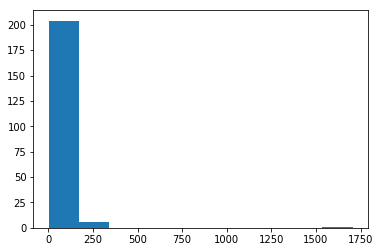

,num_business_in_cat
count,211.000000
mean,33.388626
std,126.715695
min,1.000000
0%,1.000000
25%,1.000000
50%,5.000000
75%,29.000000
80%,38.000000
85%,48.500000


In [72]:
# look at distribution of number of business per category
plt.hist(result_df['num_business_in_cat'])
plt.show()  

result_df.describe([0,0.25, 0.5,0.75,0.8,0.85,0.9,0.95,1])

In [73]:
%%time

# look at categories with less than 10 businesses
query = """
        MATCH (c:Category)
        WITH c.name AS cat, size(()-[:IN_CATEGORY]->(c)) AS num_business_in_cat  
        WHERE num_business_in_cat < 10
        RETURN cat, num_business_in_cat
        ORDER BY cat, num_business_in_cat DESC
        """

with driver.session() as session:
    result = session.run(query)


result_df = pd.DataFrame([dict(record) for record in result])
    
display(result_df.sort_values('num_business_in_cat',ascending=False).head())


,cat,num_business_in_cat
116,Turkish,9
33,Delis,9
97,Portuguese,9
18,Breweries,9
114,Taiwanese,8


CPU times: user 20 ms, sys: 4.56 ms, total: 24.6 ms
Wall time: 82.3 ms


In [75]:
# get a list of categories with less than 10 businesses
categories_to_delete = result_df['cat'].tolist()

In [76]:
%%time

# Look at number of relationships that must be first removed, before removing the categories with less than 10 busineses
query = """
        MATCH (c:Category)<-[r:IN_CATEGORY]-()
        WHERE c.name in {category_list}
        RETURN COUNT(r)
        """

with driver.session() as session:
    result = session.run(query, category_list = categories_to_delete)


result_df = pd.DataFrame([dict(record) for record in result])
    
display(result_df)

,COUNT(r)
0,354


CPU times: user 12.6 ms, sys: 6.11 ms, total: 18.7 ms
Wall time: 60.2 ms


In [77]:
%%time

# Now actually delete relationships pointing into categories to delete 
query = """
        MATCH (c:Category)<-[r:IN_CATEGORY]-()
        WHERE c.name in {category_list}
        DELETE r
        """

with driver.session() as session:
    result = session.run(query, category_list = categories_to_delete)

CPU times: user 3.34 ms, sys: 2.47 ms, total: 5.81 ms
Wall time: 70.7 ms


In [78]:
%%time

# Now remove nodes corresponding to categories to be deleted
query = """
        MATCH (c:Category)
        WHERE c.name in {category_list}
        DELETE c
        """

with driver.session() as session:
    result = session.run(query, category_list = categories_to_delete)


CPU times: user 3.03 ms, sys: 2.37 ms, total: 5.4 ms
Wall time: 37.9 ms


In [79]:
%%time

# now let's look at the categories remaining and their business counts
query = """
        MATCH (c:Category)
        RETURN c.name, size(()-[:IN_CATEGORY]->(c)) AS num_business_in_cat   
        ORDER BY c, num_business_in_cat DESC
        """

with driver.session() as session:
    result = session.run(query)

result_df = pd.DataFrame([dict(record) for record in result])
    
display(result_df.sort_values('num_business_in_cat',ascending=False).head())

,c.name,num_business_in_cat
1,Restaurants,1707
2,Food,340
8,Nightlife,335
9,Bars,330
25,Canadian (New),232


CPU times: user 14.2 ms, sys: 2.76 ms, total: 16.9 ms
Wall time: 20.8 ms


In [80]:
categories_to_delete_new = ['Restaurants','Food','Event Planning & Services','Lounges','Food Service Delivery']

In [81]:
%%time
# need to remove categories: Restaurants, Food, Event Planning & Services, Lounges as they are irrelevant
# first need to remove relationships pointing to these nodes

query = """
        MATCH (c:Category)<-[r:IN_CATEGORY]-()
        WHERE c.name in {category_list}
        RETURN COUNT(r)
        """

with driver.session() as session:
    result = session.run(query, category_list = categories_to_delete_new)


result_df = pd.DataFrame([dict(record) for record in result])
    
display(result_df)

,COUNT(r)
0,2137


CPU times: user 8.23 ms, sys: 2.98 ms, total: 11.2 ms
Wall time: 12.6 ms


In [82]:
%%time
# remove relationships pointing to these nodes

query = """
        MATCH (c:Category)<-[r:IN_CATEGORY]-()
        WHERE c.name in {category_list}
        DELETE r
        """

with driver.session() as session:
    result = session.run(query, category_list=categories_to_delete_new)

CPU times: user 2.04 ms, sys: 2.82 ms, total: 4.87 ms
Wall time: 95.6 ms


In [83]:
%%time
# remove nodes

query = """
        MATCH (c:Category)
        WHERE c.name in {category_list}
        DELETE c
        """

with driver.session() as session:
    result = session.run(query, category_list=categories_to_delete_new)

CPU times: user 2.13 ms, sys: 2.38 ms, total: 4.51 ms
Wall time: 6.91 ms


In [84]:
%%time
# check number of category nodes we now have

query = """
        MATCH (c:Category)
        RETURN COUNT(c)
        """

with driver.session() as session:
    result = session.run(query)


result_df = pd.DataFrame([dict(record) for record in result])
    
display(result_df)

,COUNT(c)
0,81


CPU times: user 7.46 ms, sys: 2.77 ms, total: 10.2 ms
Wall time: 35 ms


In [85]:
%%time
# check number of business nodes we now have

query = """
        MATCH (b:Business)
        RETURN COUNT(b)
        """

with driver.session() as session:
    result = session.run(query)


result_df = pd.DataFrame([dict(record) for record in result])
    
display(result_df)

,COUNT(b)
0,1707


CPU times: user 6.79 ms, sys: 2.71 ms, total: 9.5 ms
Wall time: 46.1 ms


In [86]:
%%time
# check number of relationships between business and category nodes

query = """
        MATCH (b:Business)-[r:IN_CATEGORY]->(c:Category)
        RETURN COUNT(r)
        """

with driver.session() as session:
    result = session.run(query)


result_df = pd.DataFrame([dict(record) for record in result])
    
display(result_df)

,COUNT(r)
0,4554


CPU times: user 7.19 ms, sys: 2.66 ms, total: 9.85 ms
Wall time: 36 ms


#### b. Load Review data into Neo4j

In [87]:
%%time

# Note: We only want to load reviews associated with the businesses already in the graph (ie: restaurants in Toronto)
# with at least 50 reviews

load_review = """
    // Load and commit every 50000 records
    USING PERIODIC COMMIT 50000 
    LOAD CSV WITH HEADERS FROM {input_dir} AS line                      
    WITH line 

    // Only care about businesses that are already in the graph (ie: Toronto restaurants)
    MATCH (business:Business {id:line.business_id})
    MERGE (user:User         {id:line.user_id})
    
    CREATE (user)-[:REVIEWED  {stars:toInteger(line.stars)}]->(business)
    """

with driver.session() as session:
    session.run(load_review, input_dir='file:///review.csv')

CPU times: user 4.26 ms, sys: 3.81 ms, total: 8.07 ms
Wall time: 1min 19s


In [88]:
%%time
# get number of businesses

query = """
        MATCH (b:Business)
        RETURN COUNT(b)
        """

with driver.session() as session:
    result = session.run(query)


result_df = pd.DataFrame([dict(record) for record in result])
    
display(result_df)

,COUNT(b)
0,1707


CPU times: user 11.1 ms, sys: 5.63 ms, total: 16.7 ms
Wall time: 17.1 ms


In [89]:
%%time
# get number of users

query = """
        MATCH (u:User)
        RETURN COUNT(u)
        """

with driver.session() as session:
    result = session.run(query)


result_df = pd.DataFrame([dict(record) for record in result])
    
display(result_df)

,COUNT(u)
0,59563


CPU times: user 7.12 ms, sys: 3.03 ms, total: 10.1 ms
Wall time: 23.3 ms


In [90]:
%%time
# get number of reviews a business has received

query = """
        MATCH (u:User)-[r:REVIEWED]->(b:Business)
        RETURN b.name, COUNT(u) as num_reviews
        """

with driver.session() as session:
    result = session.run(query)


result_df = pd.DataFrame([dict(record) for record in result])
    
display(result_df.sort_values('num_reviews',ascending=False))

,b.name,num_reviews
652,Pai Northern Thai Kitchen,1494
1255,Banh Mi Boys,1445
715,Khao San Road,1271
1074,KINKA IZAKAYA ORIGINAL,1184
1213,KINTON RAMEN,993
588,The Burger's Priest,970
1089,Terroni,946
811,Seven Lives Tacos Y Mariscos,945
352,La Carnita,879
1103,Uncle Tetsu's Japanese Cheesecake,848


CPU times: user 59.4 ms, sys: 6.73 ms, total: 66.2 ms
Wall time: 505 ms


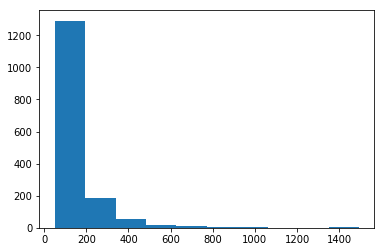

,num_reviews
count,1571.000000
mean,138.514322
std,132.489808
min,50.000000
0%,50.000000
25%,66.000000
50%,94.000000
75%,155.000000
80%,182.000000
85%,215.000000


In [91]:
# look at distribution of reviews
plt.hist(result_df['num_reviews'])
plt.show()  

result_df.describe([0,0.25, 0.5,0.75,0.8,0.85,0.9,0.95,1])

In [92]:
%%time
# get number of reviews a user has given

query = """
        MATCH (u:User)-[r:REVIEWED]->(b:Business)
        RETURN u.id, COUNT(r) as num_reviews
        """

with driver.session() as session:
    result = session.run(query)


result_df = pd.DataFrame([dict(record) for record in result])
    
display(result_df.sort_values('num_reviews',ascending=False))

,num_reviews,u.id
18763,463,CxDOIDnH8gp9KXzpBHJYXw
41951,281,TbhyP24zYZqZ2VJZgu1wrg
38092,273,0BBUmH7Krcax1RZgbH4fSA
44769,263,Q9mA60HnY87C1TW5kjAZ6Q
35307,249,FREeRQtjdJU83AFtdETBBw
53850,224,yT_QCcnq-QGipWWuzIpvtw
22663,207,gwIqbXEXijQNgdESVc07hg
54296,203,V4TPbscN8JsFbEFiwOVBKw
42912,200,1fNQRju9gmoCEvbPQBSo7w
8893,197,8HCEPF0IflyB690Q745fKg


CPU times: user 1.14 s, sys: 43.4 ms, total: 1.19 s
Wall time: 1.66 s


In [93]:
%%time
# only want users who have reviewed at least 25 businesses

query = """
        MATCH (u:User)-[r:REVIEWED]->(b:Business)
        WITH u AS usr, COUNT(r) as num_reviews
        WHERE num_reviews >= 25
        RETURN usr.id, num_reviews
        """

with driver.session() as session:
    result = session.run(query)


result_df = pd.DataFrame([dict(record) for record in result])
    
display(result_df.sort_values('num_reviews',ascending=False).head())

,num_reviews,usr.id
331,463,CxDOIDnH8gp9KXzpBHJYXw
1016,281,TbhyP24zYZqZ2VJZgu1wrg
316,273,0BBUmH7Krcax1RZgbH4fSA
739,263,Q9mA60HnY87C1TW5kjAZ6Q
322,249,FREeRQtjdJU83AFtdETBBw


CPU times: user 38.1 ms, sys: 3.82 ms, total: 41.9 ms
Wall time: 618 ms


In [94]:
%%time
# get actual list of users with less than 25 reviewed businesses

query = """
        MATCH (u:User)-[r:REVIEWED]->(b:Business)
        WITH u AS usr, COUNT(r) as num_reviews
        WHERE num_reviews < 25
        RETURN usr.id, num_reviews
        """

with driver.session() as session:
    result = session.run(query)


result_df = pd.DataFrame([dict(record) for record in result])
    
display(result_df.sort_values('num_reviews',ascending=False).head())

,num_reviews,usr.id
54373,24,Dl5twqkJmR67cq9aZl2bIA
56698,24,Srv9jOGELiNGIJEqhS5_uQ
28212,24,F54mSpDDjxr05Cb66cAKxw
9539,24,nefYrZL3vAdTd9SBPf8kPg
12298,24,0AK8CEWTh7M0ZKwQO0Hd3w


CPU times: user 1.14 s, sys: 26.1 ms, total: 1.16 s
Wall time: 1.7 s


In [95]:
users_to_delete = result_df['usr.id'].tolist()

In [96]:
%%time
# remove relationships from users identified above

query = """
        MATCH (u:User)-[r:REVIEWED]->(b:Business)
        WHERE u.id in {user_list} 
        DELETE r
        """

with driver.session() as session:
    result = session.run(query, user_list=users_to_delete)


CPU times: user 413 ms, sys: 15.2 ms, total: 428 ms
Wall time: 5.83 s


In [97]:
%%time
# remove users identified above

query = """
        MATCH (u:User)
        WHERE u.id in {user_list} 
        DELETE u
        """

with driver.session() as session:
    result = session.run(query, user_list=users_to_delete)


CPU times: user 387 ms, sys: 7.11 ms, total: 394 ms
Wall time: 3.62 s


In [98]:
%%time
# remove relationships from users identified above

query = """
        MATCH (u:User)
        RETURN COUNT( u)
        """

with driver.session() as session:
    result = session.run(query)


result_df = pd.DataFrame([dict(record) for record in result])
    
display(result_df)

,COUNT( u)
0,1251


CPU times: user 11.4 ms, sys: 3.13 ms, total: 14.5 ms
Wall time: 31 ms


#### c. Load User data into Neo4j

In [99]:
%%time

# Note: We only care about setting properties for users who are already in the graph.

load_user = """
    USING PERIODIC COMMIT 50000 
    LOAD CSV WITH HEADERS FROM {input_dir} AS line                      
    WITH line 

    // Set properties on User nodes already in the graph
    MATCH (user:User {id: line.user_id})
    SET user.name              = line.name,
        user.avg_review_rating = toFloat(line.average_stars)
    """

with driver.session() as session:
    session.run(load_user, input_dir='file:///user.csv')

CPU times: user 2.16 ms, sys: 2.54 ms, total: 4.7 ms
Wall time: 6.26 s


In [100]:
%%time
# count nodes and relationships in the graph

query = """
        MATCH (u:User)
        RETURN COUNT( u)
        """

with driver.session() as session:
    result = session.run(query)


result_df = pd.DataFrame([dict(record) for record in result])
    
display(result_df)

,COUNT( u)
0,1251


CPU times: user 7.88 ms, sys: 2.88 ms, total: 10.8 ms
Wall time: 11.3 ms


In [101]:
%%time
# count nodes and relationships in the graph

query = """
        MATCH (b:Business)
        RETURN COUNT( b)
        """

with driver.session() as session:
    result = session.run(query)


result_df = pd.DataFrame([dict(record) for record in result])
    
display(result_df)

,COUNT( b)
0,1707


CPU times: user 8.94 ms, sys: 2.98 ms, total: 11.9 ms
Wall time: 43.3 ms


In [102]:
%%time
# count nodes and relationships in the graph

query = """
        MATCH (c:Category)
        RETURN COUNT(c)
        """

with driver.session() as session:
    result = session.run(query)


result_df = pd.DataFrame([dict(record) for record in result])
    
display(result_df)

,COUNT(c)
0,81


CPU times: user 8.3 ms, sys: 2.82 ms, total: 11.1 ms
Wall time: 10.5 ms


In [104]:
%%time
# add extra step to delete businesses that do not belong to a category
# see community detection module for list of these businesses

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.06 µs


In [105]:
%%time
# count nodes and relationships in the graph

query = """
        MATCH ()-[r:IN_CATEGORY]->()
        RETURN COUNT(r)
        """

with driver.session() as session:
    result = session.run(query)


result_df = pd.DataFrame([dict(record) for record in result])
    
display(result_df)

,COUNT(r)
0,4554


CPU times: user 8.29 ms, sys: 2.94 ms, total: 11.2 ms
Wall time: 38.1 ms


In [106]:
%%time
# count nodes and relationships in the graph

query = """
        MATCH ()-[r:REVIEWED]->()
        RETURN COUNT(r)
        """

with driver.session() as session:
    result = session.run(query)


result_df = pd.DataFrame([dict(record) for record in result])
    
display(result_df)

,COUNT(r)
0,63141


CPU times: user 11.1 ms, sys: 2.74 ms, total: 13.8 ms
Wall time: 29.3 ms
